In [1]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# suppress warnings
import warnings
warnings.filterwarnings('ignore')
# load IBMQ Account data

# IBMQ.save_account('96440b89df0e15fcfd74efcb9d39f1fd68bec6cfe98bf1515381a5bd87c3f71eaa13f4d1b534cbc4fab34ed7195463a677463a44191178912d31fc75d2222a80')  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
provider = IBMQ.load_account()
# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')


/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 f

In [2]:
from qiskit import pulse
import numpy as np
pi = np.pi
from qiskit.pulse.library import Gaussian
from qiskit.pulse.library import Drag

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import Waveform
from qiskit.tools.monitor import job_monitor
from qiskit.pulse import library

import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
%matplotlib inline
import matplotlib.pyplot as plt

from qiskit import IBMQ
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# backend = provider.get_backend('ibmq_armonk')
backend = jakarta
backend_config = backend.configuration()
backend_defaults = backend.defaults()
dt = backend_config.dt

assert backend_config.open_pulse, "Backend doesn't support Pulse"

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 512*2
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)
cont_chan = pulse.ControlChannel(qubit)

def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result() # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*4        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

# Find out which measurement map index is needed for this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

f01 = default_qubit_freq
f12 = f01 - 0.33988*1e9
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")
print(f"Qubit {qubit} has an anharm frequency of {f12/ GHz} GHz.")

cal_qubit_freq = default_qubit_freq

drive_duration = drive_samples
meas = inst_sched_map.get('measure', qubits=[qubit])

Qubit 0 has an estimated frequency of 5.236542844866659 GHz.
Qubit 0 has an anharm frequency of 4.896662844866659 GHz.


In [3]:
# Qiskit pulse
from qiskit.pulse import (MemorySlot, Acquire, DriveChannel, Schedule, Waveform, 
                          InstructionScheduleMap, Play, MeasureChannel, AcquireChannel)
from qiskit.pulse.library import Gaussian
from qiskit.qobj.utils import MeasLevel, MeasReturnType
from qiskit.scheduler import measure_all
from qiskit.visualization.pulse.qcstyle import SchedStyle

# Ignis discriminator fitter tools
from sklearn.svm import SVC
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, MeasurementFilter
from qiskit.ignis.measurement.discriminator.filters import DiscriminationFilter
from qiskit.ignis.measurement.discriminator.iq_discriminators import SklearnIQDiscriminator
from scipy import interpolate, stats
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
config = backend.configuration()
defaults = backend.defaults()
inst_map = defaults.instruction_schedule_map
style = SchedStyle(figsize=(16, 5))  # schedule style plotting
default_qubit_freq = defaults.qubit_freq_est[0] # Default qubit frequency in Hz. 
xp = inst_map.get('x', (0,)).instructions[0][1].pulse
d0 = DriveChannel(0)
dt = config.dt
shots = 2048
num_shots = 2048

In [4]:
xp

Drag(duration=160, amp=(0.19676676363201234+0j), sigma=40, beta=-0.9926309952051675, name='Xp_d0')

In [5]:
import sys
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import SchedStyle

# import fitting
# import plotting

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [6]:
from qiskit.circuit import Parameter  # This is Parameter Class for variable parameters.
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)
scale_factor = 1e-14
# Rabi experiment parameters
num_rabi_points = 100

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = -0.51
drive_amp_max = 0.51
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)


In [7]:
import pandas as pd
import numpy as np
import qiskit.pulse as pulse
from qiskit.circuit import Parameter

from qiskit_experiments.calibration_management.calibrations import Calibrations

from qiskit import IBMQ, schedule

In [8]:
def add_modulation(pulse, freq: float, dt: float, scale: float = 1.) -> Waveform:
    """
    Add a modulation to the pulse.
    
    Args:
        samples: A list of AWG samples to modulate.
        freq: The frequency of the modulation to add to samples.
        dt: The cycle time.
        scale: a factor to scale the samples.
        
    Returns: SamplePulse with the added modulation.
    """
    
    if not isinstance(pulse, Waveform):
        samples = pulse.get_waveform().samples
    else:
        samples = pulse.samples
    
    modulated_samples = []
    for i, amp in enumerate(samples):
        modulated_samples.append(scale * amp * np.exp(2.0j*np.pi*freq*i*dt))
    
    return Waveform(modulated_samples)

# measurement_duration_us = 3.409090909090909
# measurement_amp = 0.9285714285714286
# measurement_duration_us = 4
# measurement_amp = 0.91
measurement_duration_us = 4.6445
measurement_amp = 0.6445
measurement_sigma_us = 0.5  # Width of the gaussian part of the rise and fall in us
measurement_risefall_us = (
        0.1  # Truncating parameter: how many samples to dedicate to the risefall
    )
measurement_sigma = get_closest_multiple_of_16(measurement_sigma_us * 1e-6 / dt)
measurement_risefall = get_closest_multiple_of_16(
        measurement_risefall_us * 1e-6 / dt
    )
measurement_duration = get_closest_multiple_of_16(
        measurement_duration_us * 1e-6 / dt
    )
calibrated_measurement_pulse = pulse_lib.gaussian_square(
        duration=measurement_duration,
        sigma=measurement_sigma,
        amp=measurement_amp,
        risefall=measurement_risefall,
        name="measurement_pulse",
)

# Add a measurement stimulus on the measure channel pulse to trigger readout
calibrated_measure_schedule = pulse.Play(calibrated_measurement_pulse, meas_chan)

# Trigger data acquisition, and store measured values into respective memory slots
calibrated_measure_schedule += pulse.Acquire(
        calibrated_measurement_pulse.duration,
        pulse.AcquireChannel(backend_config.meas_map[meas_map_idx][0]),
        pulse.MemorySlot(backend_config.meas_map[meas_map_idx][0]),
)
meas_freq_shift = -0.075e6
meas_pulse= add_modulation(calibrated_measurement_pulse, meas_freq_shift, dt, scale=1)
# meas_pulse = calibrated_measurement_pulse
meas_sched = Schedule(name='meas %f' % meas_freq_shift)
meas_sched += Play(meas_pulse, MeasureChannel(0))
meas_sched += Acquire(len(meas_pulse.samples), AcquireChannel(0), MemorySlot(0))

In [9]:
def get_job_data(job, average: bool, qubit: int, scale_factor=1):
    """Retrieve data from a job that has already run.
    
    Args:
        job (Job): The job whose data you want.
        average: If True, gets the data assuming data is an average.
                 If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=3600) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def lorenz(x, a, q_freq, b, c):
     return (a / np.pi) * (b / ((x - q_freq)**2 + b**2)) + c

In [10]:
def get_closest_multiple_of_16(num):
    return int(num + 8) - (int(num + 8) % 16)
backend_config = backend.configuration()
drive_chan = pulse.DriveChannel(0)

# Set measurement channels
meas_chan = pulse.MeasureChannel(0)
acq_chan = pulse.AcquireChannel(0)
qubit = 0
meas_map_idx = 0
backend_defaults = backend.defaults()
backend_config = backend.configuration()
drive_chan = DriveChannel(qubit)
meas_chan = MeasureChannel(qubit)
inst_sched_map = backend_defaults.instruction_schedule_map
measure_schedule = inst_sched_map.get(
"measure", qubits=backend_config.meas_map[qubit])

In [11]:
anh=-0.33988*1e9

In [12]:
xp12_scale=0.68501394194472245

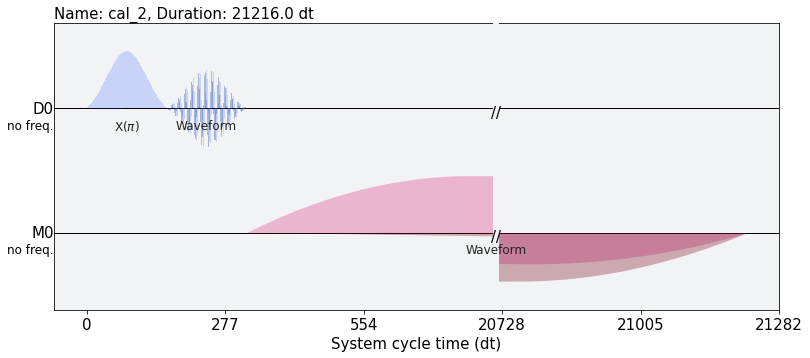

In [13]:
anh = f12-f01
schedules_cal = []
# meas_sched = meas
d0 = drive_chan
cal0 = Schedule(name='cal_0')
cal0 += meas_sched << cal0.duration
schedules_cal.append(cal0)

cal1 = Schedule(name='cal_1')
cal1 += Play(xp, d0) << cal1.duration
cal1 += meas_sched << cal1.duration
schedules_cal.append(cal1)

# Create the calibrated pi-pulse between |1> and |2>
xp12add = add_modulation(xp, anh, dt,scale = xp12_scale)
cal2 = Schedule(name='cal_2')
cal2 += Play(xp, d0)
# cal2 += pulse.ShiftFrequency(anh, drive_chan)
cal2 += Play(xp12add, d0)
cal2 += meas_sched << cal2.duration

schedules_cal.append(cal2)
schedules_cal[2].draw()

In [14]:
pi = np.pi
cos = np.cos
sin = np.sin
exp = np.exp
sqrt = np.sqrt
def Rx_01(theta):
    Rx_01 = np.array([[cos(theta/2)     , -1j*sin(theta/2) , 0],
                      [-1j*sin(theta/2) , cos(theta/2)     , 0],
                      [0                , 0                , 1]])
    return Rx_01

def Rx_12(theta):
    Rx_12 = np.array([[1 , 0                , 0               ],
                      [0 , cos(theta/2)     , -1j*sin(theta/2)],
                      [0 , -1j*sin(theta/2) , cos(theta/2)    ]])
    return Rx_12

def Ry_01(theta):
    Ry_01 = np.array([[cos(theta/2) , -sin(theta/2) , 0],
                      [sin(theta/2) , cos(theta/2)  , 0],
                      [0            , 0             , 1]])
    return Ry_01

def Ry_12(theta):
    Ry_12 = np.array([[1 , 0            , 0            ],
                      [0 , cos(theta/2) , -sin(theta/2)],
                      [0 , sin(theta/2) , cos(theta/2) ]])
    return Ry_12

def Rz_01(theta):
    Rz_01 = np.array([[exp((-1j*theta)/2) , 0                 , 0],
                      [0                  , exp((1j*theta)/2) , 0],
                      [0                  , 0                 , 1]])
    return Rz_01

def Rz_12(theta):
    Rz_12 = np.array([[1 , 0                  , 0                ],
                      [0 , exp((-1j*theta)/2) , 0                ],
                      [0 , 0                  , exp((1j*theta)/2)]])
    return Rz_12
t12 = np.radians(33.45)
t23 = np.radians(42.1)
t13 = np.radians(8.62)
D21 = 7.42*1e-5
D31 = 2.510*1e-3 
D32 = D31-D21 ###
# Now gate simulator
c12 = cos(t12)
s12 = sin(t12)
c13 = cos(t13)
s13 = sin(t13)
c23 = cos(t23)
s23 = sin(t23)

In [16]:
pi = np.pi
cos = np.cos
sin = np.sin
exp = np.exp
sqrt = np.sqrt
def Rx01(theta):
    Rx_01 = np.array([[cos(theta/2)     , -1j*sin(theta/2)],
                      [-1j*sin(theta/2) , cos(theta/2)]])
    return Rx_01

def Rz01(theta):
    Rz_01 = np.array([[exp((-1j*theta)/2) , 0             ],
                      [0                  , exp((1j*theta)/2)]
                      ])
    return Rz_01
def P0(phi):
    Rz_01 = np.array([[exp(1j*phi) , 0                 , 0],
                      [0                  , 1 , 0],
                      [0                  , 0                 , 1]])
    return Rz_01

def P2(theta):
    Rz_12 = np.array([[1 , 0                  , 0                ],
                      [0 , 1 , 0                ],
                      [0 , 0                  , exp((1j*theta))]])
    return Rz_12

In [17]:
#Rx01 Rx12
def rx01(theta):
    pulse.play(pulse.Drag(duration=160, amp=xp.amp*theta/pi, sigma=40, beta=0), drive_chan) 
    return rx01
def rx12(theta):
    pulse.play(add_modulation(xp, anh, dt,scale = xp12_scale*theta/pi), drive_chan) 
    return rx12

In [18]:
### Start from electron
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import pandas as pd
import seaborn as sns
#bodacious colors
colors=sns.color_palette("rocket",3)
#Ram's colors, if desired
seshadri = ['#c3121e', '#0348a1', '#ffb01c', '#027608', '#0193b0', '#9c5300', '#949c01', '#7104b5']
#            0sangre,   1neptune,  2pumpkin,  3clover,   4denim,    5cocoa,    6cumin,    7berry

In [19]:
def parameters(a):
    Dee = c12**2*D31+s12**2*D32
    Dee_t = Dee*sqrt((cos(2*t13)-a/Dee)**2+sin(2*t13)**2)
    s13t_sq = 0.5*(1-(Dee*cos(2*t13)-a)/Dee_t)
    t13t = np.arcsin(sqrt(s13t_sq))
    a12 = 0.5*(a+Dee-Dee_t)
    D21t = D21*sqrt((cos(2*t12)-a12/D21)**2 + cos(t13-t13t)**2*sin(2*t12)**2)
    s12t_sq = 0.5*(1-(D21*cos(2*t12)-a12)/D21t)
    t12t = np.arcsin(sqrt(s12t_sq))
    D31t = D31+a/4+0.5*(D21t-D21)+0.75*(Dee_t-Dee)
    t23t = t23
    return t23t,t13t, t12t, D21t, D31t
def NeudCPMatter(dCP, initial, matter, sim):
    try:
        if initial == 'e':
            flavor_initial = [1,0,0]
        elif initial == 'm':
            flavor_initial = [0,1,0]
        elif initial == 't':
            flavor_initial = [0,0,1]
    except:
        print('start from e, m, t only')
    t23m, t13m, t12m, D21m, D31m = parameters(matter)
    dCPm = dCP
    c12m = cos(t12m)
    s12m = sin(t12m)
    c13m = cos(t13m)
    s13m = sin(t13m)
    c23m = cos(t23m)
    s23m = sin(t23m)
    
    Um = np.array([[c12m*c13m            , s12m*c13m             , s13m*exp(-1j*dCP)],
               [-s12m*c23m-c12m*s23m*s13m*exp(1j*dCP), c12m*c23m-s12m*s23m*s13m*exp(1j*dCP) , s23m*c13m],
               [s12m*s23m-c12m*c23m*s13m*exp(1j*dCP) , -c12m*s23m-s12m*c23m*s13m*exp(1j*dCP), c23m*c13m]])
    iUm = Um.conj().T
    # U1 = R01(pi/2+dCP, a1m)@R12(3*pi/2, a2m)@R01(pi/2+dCP, a3)@R01(pi/2,-2*t12m)
    # U1d = R01(pi/2, 2*t12m)@R01(pi/2+dCP, -a3m)@R12(3*pi/2, -a2m)@R01(pi/2+dCP, -a1m)
    e_survival1a = []
    mu_survival1a = []
    tau_survival1a = []
    
    for l in sim:
        evolmatrix = np.diag([1, exp(-1j*D21m*l/(2*E)), exp(-1j*l*D31m/(2*E))])
        # flavor = U1@evolmatrix@U1d@flavor_initial
        flavor = Um@evolmatrix@iUm@flavor_initial
        e_survival1a.append(np.absolute(flavor[0])**2)
        mu_survival1a.append(np.absolute(flavor[1])**2)
        tau_survival1a.append(np.absolute(flavor[2])**2)
    return e_survival1a, mu_survival1a, tau_survival1a

In [20]:
pha =   [1.70182699, -6.28318552, -0.04969043,  3.29814726, -6.43057016]

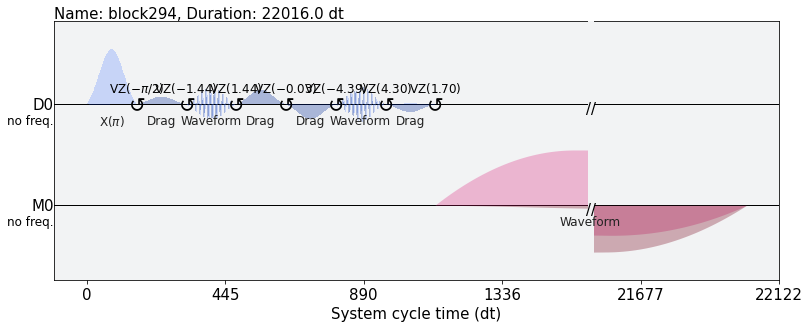

In [20]:
# pha 7
matter = 0
t23m, t13m, t12m, D21m, D31m = parameters(matter)
c12m = cos(t12m)
s12m = sin(t12m)
c13m = cos(t13m)
s13m = sin(t13m)
c23m = cos(t23m)
s23m = sin(t23m)
E = 0.2*5
dCP = 0
L = 295
conv = 5
Lmin = 0
Lmax = 34000

timestep = 297
Lreal = np.linspace(Lmin,Lmax,timestep)
a2 = 2*np.arccos(cos(t13m)*cos(t23m))
a1 = -2*np.arccos(cos(t13m)*sin(t23m)/sin(a2/2))
a3 = 2*np.arccos(cos(a1/2)/cos(t13m))
schedules = [cal0, cal1, cal2]

for ii, l in enumerate(Lreal):
  
    d2 = D21m*l*conv/(2*E)
    d3 = D31m*l*conv/(2*E)
    alpha = d2
    beta = -d2+d3
    with pulse.build(backend=backend, default_alignment="sequential") as neu_sched:
        ## PMNS dagger
        pulse.play(xp, drive_chan)
        with pulse.phase_offset(pi/2, drive_chan):
            rx01(-a1)
        with pulse.phase_offset((1.5*pi-pha[0])%(2*pi) , drive_chan):
            rx12(-a2)
        with pulse.phase_offset((pi/2-pha[1])%(2*pi), drive_chan):
            rx01(-a3+2*t12m)
        ## evolution x PMNS
        with pulse.phase_offset((dCP+alpha+pi/2-pha[2])%(2*pi) , drive_chan):
            rx01(a3-2*t12m)
        with pulse.phase_offset((beta+1.5*pi-pha[3])%(2*pi), drive_chan):
            rx12(a2)
        with pulse.phase_offset((alpha+pi/2-pha[4])%(2*pi), drive_chan):
            rx01(a1)
        pulse.call(meas_sched)
    schedules.append(neu_sched)
schedules[-3].draw()

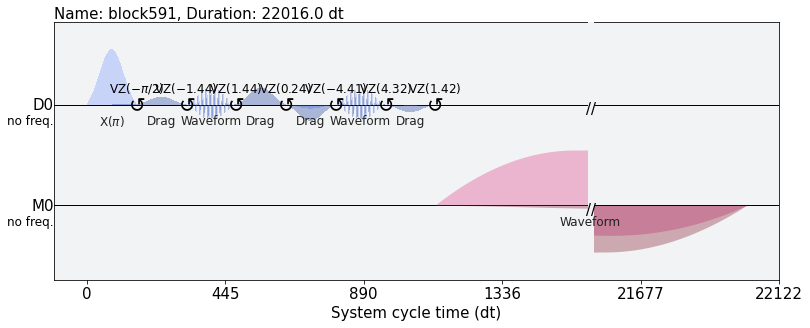

In [22]:
# pha 7
matter = 1e-5
t23m, t13m, t12m, D21m, D31m = parameters(matter)
c12m = cos(t12m)
s12m = sin(t12m)
c13m = cos(t13m)
s13m = sin(t13m)
c23m = cos(t23m)
s23m = sin(t23m)
E = 0.2*5
dCP = 0
L = 295
t = L
conv = 5
Lmin = 0
Lmax = 34000

timestep = 297
Lreal = np.linspace(Lmin,Lmax,timestep)
a2 = 2*np.arccos(cos(t13m)*cos(t23m))
a1 = -2*np.arccos(cos(t13m)*sin(t23m)/sin(a2/2))
a3 = 2*np.arccos(cos(a1/2)/cos(t13m))
schedules = [cal0, cal1, cal2]

for ii, l in enumerate(Lreal):
  
    d2 = D21m*l*conv/(2*E)
    d3 = D31m*l*conv/(2*E)
    alpha = d2
    beta = -d2+d3
    with pulse.build(backend=backend, default_alignment="sequential") as neu_sched:
        ## PMNS dagger
        pulse.play(xp, drive_chan)
        with pulse.phase_offset(pi/2, drive_chan):
            rx01(-a1)
        with pulse.phase_offset((1.5*pi-pha[0])%(2*pi) , drive_chan):
            rx12(-a2)
        with pulse.phase_offset((pi/2-pha[1])%(2*pi), drive_chan):
            rx01(-a3+2*t12m)
        ## evolution x PMNS
        with pulse.phase_offset((dCP+alpha+pi/2-pha[2])%(2*pi) , drive_chan):
            rx01(a3-2*t12m)
        with pulse.phase_offset((beta+1.5*pi-pha[3])%(2*pi), drive_chan):
            rx12(a2)
        with pulse.phase_offset((alpha+pi/2-pha[4])%(2*pi), drive_chan):
            rx01(a1)
        pulse.call(meas_sched)
    schedules.append(neu_sched)
schedules[-3].draw()

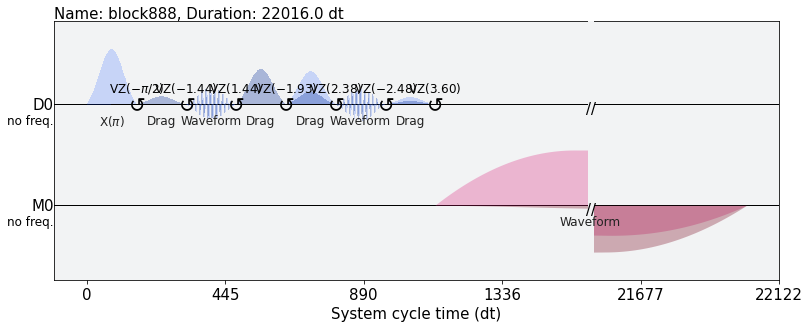

In [24]:
# pha 7
matter = 1e-4
t23m, t13m, t12m, D21m, D31m = parameters(matter)
c12m = cos(t12m)
s12m = sin(t12m)
c13m = cos(t13m)
s13m = sin(t13m)
c23m = cos(t23m)
s23m = sin(t23m)
E = 0.2
dCP = 0
L = 295
conv = 5
Lmin = 0
Lmax = 34000

timestep = 297
Lreal = np.linspace(Lmin,Lmax,timestep)
a2 = 2*np.arccos(cos(t13m)*cos(t23m))
a1 = -2*np.arccos(cos(t13m)*sin(t23m)/sin(a2/2))
a3 = 2*np.arccos(cos(a1/2)/cos(t13m))
schedules = [cal0, cal1, cal2]

for ii, l in enumerate(Lreal):
  
    d2 = D21m*l*conv/(2*E)
    d3 = D31m*l*conv/(2*E)
    alpha = d2
    beta = -d2+d3
    with pulse.build(backend=backend, default_alignment="sequential") as neu_sched:
        ## PMNS dagger
        pulse.play(xp, drive_chan)
        with pulse.phase_offset(pi/2, drive_chan):
            rx01(-a1)
        with pulse.phase_offset((1.5*pi-pha[0])%(2*pi) , drive_chan):
            rx12(-a2)
        with pulse.phase_offset((pi/2-pha[1])%(2*pi), drive_chan):
            rx01(-a3+2*t12m)
        ## evolution x PMNS
        with pulse.phase_offset((dCP+alpha+pi/2-pha[2])%(2*pi) , drive_chan):
            rx01(a3-2*t12m)
        with pulse.phase_offset((beta+1.5*pi-pha[3])%(2*pi), drive_chan):
            rx12(a2)
        with pulse.phase_offset((alpha+pi/2-pha[4])%(2*pi), drive_chan):
            rx01(a1)
        pulse.call(meas_sched)
    schedules.append(neu_sched)
schedules[-3].draw()

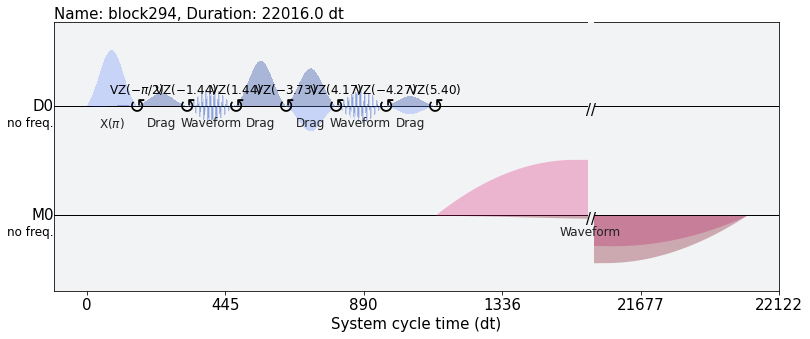

In [21]:
# pha 7
matter = 1e-3
t23m, t13m, t12m, D21m, D31m = parameters(matter)
c12m = cos(t12m)
s12m = sin(t12m)
c13m = cos(t13m)
s13m = sin(t13m)
c23m = cos(t23m)
s23m = sin(t23m)
E = 0.2
dCP = 0
L = 295
conv = 5
Lmin = 0
Lmax = 34000

timestep = 297
Lreal = np.linspace(Lmin,Lmax,timestep)
a2 = 2*np.arccos(cos(t13m)*cos(t23m))
a1 = -2*np.arccos(cos(t13m)*sin(t23m)/sin(a2/2))
a3 = 2*np.arccos(cos(a1/2)/cos(t13m))
schedules = [cal0, cal1, cal2]

for ii, l in enumerate(Lreal):
  
    d2 = D21m*l*conv/(2*E)
    d3 = D31m*l*conv/(2*E)
    alpha = d2
    beta = -d2+d3
    with pulse.build(backend=backend, default_alignment="sequential") as neu_sched:
        ## PMNS dagger
        pulse.play(xp, drive_chan)
        with pulse.phase_offset(pi/2, drive_chan):
            rx01(-a1)
        with pulse.phase_offset((1.5*pi-pha[0])%(2*pi) , drive_chan):
            rx12(-a2)
        with pulse.phase_offset((pi/2-pha[1])%(2*pi), drive_chan):
            rx01(-a3+2*t12m)
        ## evolution x PMNS
        with pulse.phase_offset((dCP+alpha+pi/2-pha[2])%(2*pi) , drive_chan):
            rx01(a3-2*t12m)
        with pulse.phase_offset((beta+1.5*pi-pha[3])%(2*pi), drive_chan):
            rx12(a2)
        with pulse.phase_offset((alpha+pi/2-pha[4])%(2*pi), drive_chan):
            rx01(a1)
        pulse.call(meas_sched)
    schedules.append(neu_sched)
schedules[-3].draw()

In [34]:
shots = 1024*8
qobj = assemble(schedules, backend, meas_level=1, 
                meas_return=MeasReturnType.SINGLE,
                shots=shots, rep_delay=0.0005)
job = backend.run(qobj)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

6249de06e978c7f484fb2059
Job Status: job is queued (114)   

KeyboardInterrupt: 

In [ ]:
# calibrated_measurement_pulse _ MUON 
6249da6a7130e146f25b2dff
6249db59f9156f0727cc0311
6249db929962251fb18bb609
6249dbc8b3213d0788c062de

In [29]:
# job = backend.retrieve_job('6249db929962251fb18bb609')
# job = backend.retrieve_job('6249dd471a95e078ca5cdd6f')

job = backend.retrieve_job('6249db929962251fb18bb609')
job_result = job.result(timeout=3600)

In [ ]:
import time
import warnings
from pathlib import Path
timestr = time.strftime("%Y%m%d-%H%M%S")
print("Time label for data saved throughout this experiment:" + timestr)
data_folder = Path('/home/jovyan/NO/data') # CHANGE TO YOUR DIRECTORY

In [ ]:
# raw_data_list = job.result()
import jsonpickle
def save_var(file_name, var):
    # Save a single variable to a file using jsonpickle
    f = open(file_name, "w+")
    to_write = jsonpickle.encode(var)
    f.write(to_write)
    f.close()

def load_var(file_name):
    # Return a variable from a json file
    f = open(file_name, "r+")
    encoded = f.read()
    decoded = jsonpickle.decode(encoded)
    f.close()
    return decoded

In [30]:
shots = 2048*4
cal_result_disc = job.result(timeout=3600)
geom_result = cal_result_disc
# [cal0, cal1, cal2]
svc = SVC(C=0.01, kernel="rbf", gamma="scale")
svc_discriminator = SklearnIQDiscriminator(svc, geom_result, [0], ['0', '1', '10'])
filter012 = DiscriminationFilter(svc_discriminator)
# Apply discriminator
geom_discriminated = filter012.apply(geom_result)
cal_counts = filter012.apply(cal_result_disc).get_counts()
cal_matrix = np.array([[cal_counts[0].get('0',0), cal_counts[1].get('0',0), cal_counts[2].get('0',0)],
                       [cal_counts[0].get('1',0), cal_counts[1].get('1',0), cal_counts[2].get('1',0)],
                       [cal_counts[0].get('10',0), cal_counts[1].get('10',0), cal_counts[2].get('10',0)]])/shots
meas_filter = MeasurementFilter(cal_matrix, ['0', '1', '10'])
print(cal_matrix)
# Mitigate readout errors
geom_mitigated = meas_filter.apply(geom_discriminated)
# Compute the population counts
counts = geom_mitigated.get_counts()

[[0.96533203 0.03222656 0.00866699]
 [0.0090332  0.92993164 0.05529785]
 [0.02563477 0.0378418  0.93603516]]


In [31]:
pop0p = [cnt.get('0',0)/shots for cnt in counts[3:]]
pop1p = [cnt.get('1',0)/shots for cnt in counts[3:]]
pop2p = [cnt.get('10',0)/shots for cnt in counts[3:]]

In [41]:
pop0 = [cnt.get('0',0)/shots for cnt in counts[3:]]
pop1 = [cnt.get('1',0)/shots for cnt in counts[3:]]
pop2 = [cnt.get('10',0)/shots for cnt in counts[3:]]

In [53]:
pop0p1 = [cnt.get('0',0)/shots for cnt in counts[3:]]
pop1p1 = [cnt.get('1',0)/shots for cnt in counts[3:]]
pop2p1 = [cnt.get('10',0)/shots for cnt in counts[3:]]

In [28]:
pop0t = [cnt.get('0',0)/shots for cnt in counts[3:]]
pop1t = [cnt.get('1',0)/shots for cnt in counts[3:]]
pop2t = [cnt.get('10',0)/shots for cnt in counts[3:]]

In [24]:
pop0p3 = [cnt.get('0',0)/shots for cnt in counts[3:]]
pop1p3 = [cnt.get('1',0)/shots for cnt in counts[3:]]
pop2p3 = [cnt.get('10',0)/shots for cnt in counts[3:]]

In [28]:
def R01(phi, theta):
    M = P0(-phi)@Rx_01(theta)@P0(phi)
    return M
def R12(phi, theta):
    M = P2(phi)@Rx_12(theta)@P2(-phi)
    return M
a2m = 2*np.arccos(cos(t13m)*cos(t23m))
a1m = -2*np.arccos(cos(t13m)*sin(t23m)/sin(a2/2))
a3m = 2*np.arccos(cos(a1/2)/cos(t13m))
U1 = R01(pi/2+dCP, a1m)@R12(3*pi/2, a2m)@R01(pi/2+dCP, a3)@R01(pi/2,-2*t12m)
U1d = R01(pi/2, 2*t12m)@R01(pi/2+dCP, -a3)@R12(3*pi/2, -a2m)@R01(pi/2+dCP, -a1m)
np.round(U1@U1d,3), np.round(U1d@U1,3)

(array([[ 1.-0.j,  0.-0.j,  0.+0.j],
        [ 0.-0.j,  1.+0.j, -0.+0.j],
        [ 0.-0.j,  0.-0.j,  1.+0.j]]),
 array([[ 1.+0.j, -0.-0.j, -0.+0.j],
        [-0.+0.j,  1.+0.j,  0.+0.j],
        [-0.+0.j,  0.-0.j,  1.+0.j]]))

In [30]:
np.savetxt('/home/jovyan/AprilData/pop0tau.txt',(pop0t,pop1t,pop2t))

In [25]:
np.savetxt('/home/jovyan/AprilData/pop_muon_matter_power_minus3.txt',(pop0p3,pop1p3,pop2p3))

In [32]:
np.savetxt('/home/jovyan/AprilData/pop_muon_matter_power_minus5.txt',(pop0p,pop1p,pop2p))